## Predicting House Prices
This assignment tasks us with using linear regression to predict house prices from [Kaggle's house prices dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).  The data consists of sales price (the target), 79 features, and an id column.  

Details of each feature can be found in the link above, but the features can split into 9 categories: 1) type of dwelling, 2) zoning information, 3) lot information, 4) utilities, 5) neighborhood, 6) conditions, 7) quality, 8) exterior information, and 9) rooms information.  

### 1 - Load and Inspect Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
from tabulate import tabulate
import statsmodels.api as sm
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('houseprices.cvs')

### 2 - Data Prepping
I dealt with the numerical and categorical features separately.  

#### 2.1 - Numerical Features
For the numerical features, I used a correlation matrix to see which features were highly correlated with sales prices.  There were 6 features: overall quality, living area square footage, number of cars that could fit in the garage, garage area, total basement square footage, and first floor square footage.  Two of these were highly correlated with each other and were removed (garage area and first floor square footage).  

In [3]:
num_col = ['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf']

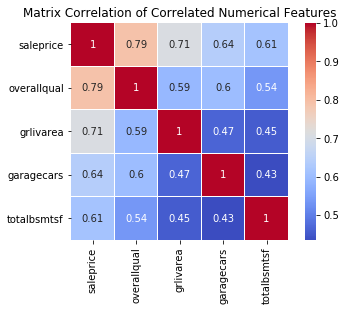

In [4]:
sns.heatmap(np.absolute(pd.concat([df['saleprice'], df[num_col]], axis = 1).corr()), 
            square = True, annot = True, linewidth = 0.1, cmap = 'coolwarm')
plt.title('Matrix Correlation of Correlated Numerical Features')

#### 2.2 - Categorial Features

### 4 - Looking at Categorical Features
One hot encoding can quickly multiply the number of features, especially if there are a lot of unique values.  For brevity I only used features with less than 6 unique values and one hot encoded them.  But before that, I had to deal with missing data.  For the most part, if data is missing it is because there is no feature to categorize.  For example, the feature pool quality has missing values because the house has no pool.

In [5]:
cat_col = [col for col in df.columns if df[col].dtype == 'object']

#### 4.1 - Missing Data


In [6]:
cat_col_less = [col for col in cat_col if df[col].nunique() < 6]

##### 4.1.1 - Alley
Alley is one of those with more than 50% missing values.  It will be interesting to see if this feature affects sale prices or not.  At the moment, it has two unique values: 'Grvl' and 'Pave', which represents if the alley to access the property is gravel or paved.  Houses without a value most likely indicate they do not have an alley.  In this case, I can impute 'None' to indicate there is no alley.

In [7]:
df['alley'].fillna('None', inplace = True)

##### 4.1.2 - Masonry Veneer Type
There are about 0.5% missing values from this feature, and unlike the alley feature, there is already a category for 'None'.  This 'None' category is by car the most common veneer type, so I will fill in missing values with 'None'.  

In [8]:
df['masvnrtype'].fillna('None', inplace = True)

##### 4.1.3 - Basement 
There are three features that are related to the basement: basement quality, basement conditions, and basement exposure.  The quality evaluates the height of the basement whereas the condition evaluates the general condition of the basement.  Both have ratings of good, typical, excellent, or fair.  If there is no value, then there is no basement.  

Basement exposure refers to the garden level walls, and exposures are rated as good, average, minimum, or no exposure.  Similarly, if the value is missing there is no basement.  

In [9]:
df['bsmtqual'].fillna('None', inplace = True)
df['bsmtcond'].fillna('None', inplace = True)
df['bsmtexposure'].fillna('None', inplace = True)

##### 4.1.4 - Electrical
There is one missing value from the electrical feature, which indicates what type of fuse box the house has.  Since electricity is one of the requirements for a home, it is safe to assume this was a mistake.  By far, the most common type of fuse is a standard breaker (SBrkr), so I will fill in the missing row with this value.

In [10]:
df['electrical'].fillna('SBrkr', inplace = True)

##### 4.1.5 - Fireplace Quality
Fireplace quality defines the condition of the fireplace, where values can be excellent, good, fair, typical, and poor.  If there is a missing value, it means there are no fireplaces.  As such, I will fill in missing values with 'None'.

In [11]:
df['fireplacequ'].fillna('None', inplace = True)

##### 4.1.6 - Garage
From the numerical section, I'm going to guess garages affect the sale prices a lot.  Categorical features relating to garages are garage finish, quality, and condition.  There are 81 missing values for each of these features, and there are 81 homes with 0 cars that fit in the garage (most likely doesn't have a garage).  The missing values here will be filled in with 'None'.

In [12]:
for col in ['garagefinish', 'garagequal', 'garagecond']:
    df[col].fillna('None', inplace = True)

##### 4.1.7 - Pool Quality
There are 1453 homes missing a value in pool quality, which corresponds to the number of homes that do not have a pool.  These homes will have a pool quality of 'None'.  

In [13]:
df['poolqc'].fillna('None', inplace  = True)

##### 4.1.8 - Fence
The fence feature refers to the level of privacy a fence provides.  If there is a missing value, it means there is no fence.  

In [14]:
df['fence'].fillna('None', inplace = True)

##### 4.1.9 - Miscellaneous Features
This feature is a catch all for houses that have stranger ammenities such as elevators, tennis courts, and sheds.  If there are no miscellaneous features, then it is reflected as a missing value.  These will be converted to 'None'.  

In [15]:
df['miscfeature'].fillna('None', inplace = True)

#### 4.2 - Creating Dummy Variables
Now that the missing values has been imputed, it is time to create dummy variables.  

In [16]:
df2 = df[num_col]

In [17]:
for col in cat_col_less:
    df2 = pd.concat([df2, pd.get_dummies(df[col], drop_first=True, prefix = col)], axis = 1)

### 5 - OLS Model with Numerical and Categorical Features
With these features, this model gives an R-squared value of 0.85.

In [18]:
df3 = pd.concat([df2, df['saleprice']], axis = 1)

In [19]:
Y = df3['saleprice']
X = df3.drop('saleprice', axis = 1)
lrm = linear_model.LinearRegression()
lrm.fit(X, Y)
print('Coefficients: ', lrm.coef_)
print('Intercept: ', lrm.intercept_)

Coefficients:  [  1.05669812e+04   4.61627823e+01   1.30681986e+04   1.70243023e+01
   4.48048105e+04   3.56438000e+04   3.56629808e+04   2.46231215e+04
   6.67181577e+03   5.24644488e+03   1.32946615e+03   8.35741769e+03
  -2.60197895e+04  -1.29352677e+03   2.30650227e+04   1.99324888e+04
   1.68806134e+04  -3.87397380e+04   1.37650794e+04  -6.50311267e+03
  -2.60953532e+03   1.39667125e+03   8.79231485e+03   2.11779573e+03
  -1.05560413e+04  -2.28599882e+04  -1.70954948e+04  -1.52780742e+04
   1.42902797e+04   1.30860762e+04   1.75557235e+04  -2.82062123e+04
  -2.36528947e+04  -3.21776893e+04  -1.45114005e+04  -7.53804198e+03
  -4.53146163e+04  -1.07575240e+04  -3.66791901e+04  -3.06162861e+04
   1.69634095e+03  -3.57889812e+04   1.06676991e+04   1.69634095e+03
  -1.56080582e+04   1.20683444e+04   1.90719543e+04  -1.47935667e+03
  -8.78338435e+03  -3.04352152e+04  -3.65794364e+03  -4.81352622e+03
  -2.10231593e+04  -2.87554211e+03   6.59323003e+03   3.53528748e+02
   1.79162423e+04  

### 3 -  Gauss Markov Conditions

#### 3.1 - Linearity of the Model in its Coefficients
Plotting the numerical features against the target can tell us if the coeffients are linear. In this case, **the assumptions of this condition are met.**

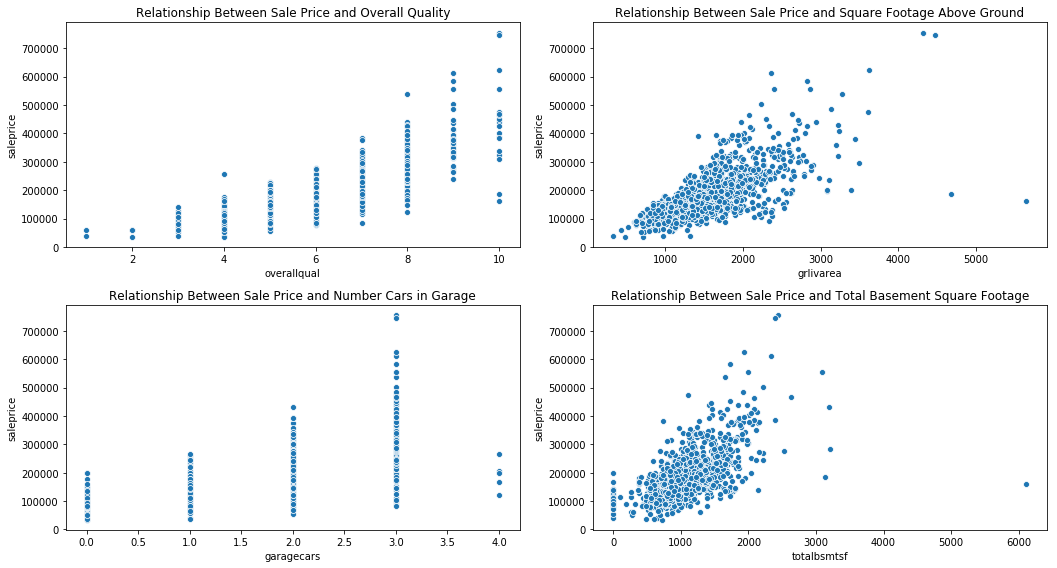

In [20]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2,2,figsize=(15,8))

sns.scatterplot(x = 'overallqual', y = 'saleprice', data = df3, ax = axis1)
sns.scatterplot(x = 'grlivarea', y = 'saleprice', data = df3, ax = axis2)
sns.scatterplot(x = 'garagecars', y = 'saleprice', data = df3, ax = axis3)
sns.scatterplot(x = 'totalbsmtsf', y = 'saleprice', data = df3, ax = axis4)

axis1.set_title('Relationship Between Sale Price and Overall Quality')
axis2.set_title('Relationship Between Sale Price and Square Footage Above Ground')
axis3.set_title('Relationship Between Sale Price and Number Cars in Garage')
axis4.set_title('Relationship Between Sale Price and Total Basement Square Footage')

plt.tight_layout()

#### 3.2 - The Error Term Should be Zero On Average
The mean error is to 10^-11, which is pretty much zero.  **The assumptions of this condition are met.**

In [21]:
pred = lrm.predict(X)
errors = Y - pred

In [22]:
print('Mean of errors in temperature is {}.'.format(np.mean(errors)))

Mean of errors in temperature is 4.044635068267992e-11.


#### 3.3 - Homoscedasticity
Figuring out if a model is hetero or homoscedacity can be done visually and mathematically.  Visually, we plot the predictions and errors, and data points should be evenly distributed around x = 0.  In the plot below, it is relatively well distributed until the predicted value is above 350k.  

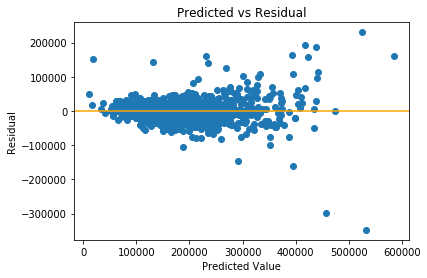

In [23]:
plt.scatter(pred, errors)
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.axhline(y = 0, color = 'orange')
plt.title('Predicted vs Residual')

Statistical models for homoscedasity are the Bartlett and Levene tests.  Here, the null hypothesis is that the model is homoscedastic.  The results for both tests have p-values under 0.05, so the null hypothesis is rejected.  **The model is heteroscedastic and the assumptions of this model are not met**.  As the plot implies, most likely the model is estimating sale prices above $350k incorrectly.

In [24]:
saleprice_bartlett = bartlett(pred, errors)
saleprice_levene = levene(pred, errors)

In [25]:
print('The Bartlett test value is {0:3g} with a p-value of {1:.3g}.'.format(saleprice_bartlett[0], saleprice_bartlett[1]))
print('The Levene test value is {0:3g} with a p-value of {1:.3g}.'.format(saleprice_levene[0], saleprice_levene[1]))

The Bartlett test value is 984.236 with a p-value of 4.8e-216.
The Levene test value is 646.669 with a p-value of 5.04e-129.


##### 3.3.1 - How to we fix heteroscedacity?  
From the plot above, there are outliers mostly when sale prices are over \$350k.  The plot below shows that the distribution of sale prices is not normally distributed.  In fact, it is right skewed, with much of the skew at \$400k and above.  It is possible that taking the log of sale prices will create a more homoscedastic model.  

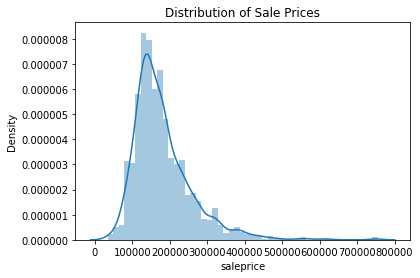

In [26]:
sns.distplot(df3['saleprice'])
plt.title('Distribution of Sale Prices')
plt.ylabel('Density')

In [36]:
Y1 = np.log(df3['saleprice'])
X1 = df3.drop('saleprice', axis = 1)
lrm1 = linear_model.LinearRegression()
lrm1.fit(X1, Y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [51]:
pred1 = lrm1.predict(X1)
errors1 = Y1 - pred1

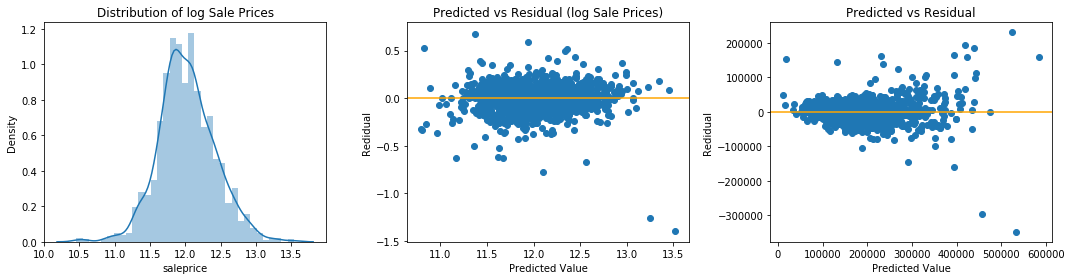

In [52]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(15,4))

sns.distplot(np.log(df3['saleprice']), ax = axis1)
axis2.scatter(pred1, errors1)
axis3.scatter(pred, errors)

for ax in [axis2, axis3]:
    ax.set_xlabel('Predicted Value')
    ax.set_ylabel('Redidual')
    ax.axhline(y = 0, color = 'orange')

axis1.set_title('Distribution of log Sale Prices')
axis1.set_ylabel('Density')
axis2.set_title('Predicted vs Residual (log Sale Prices)')
axis3.set_title('Predicted vs Residual')
plt.tight_layout()

In [53]:
saleprice_bartlett1 = bartlett(pred1, errors1)
saleprice_levene1 = levene(pred1, errors1)

In [54]:
print('The Bartlett test value for log sale price is {0:3g} with a p-value of {1:.3g}.'.format(saleprice_bartlett1[0], saleprice_bartlett1[1]))
print('The Levene test value for log sale price is {0:3g} with a p-value of {1:.3g}.'.format(saleprice_levene1[0], saleprice_levene1[1]))

The Bartlett test value for log sale price is 1252.46 with a p-value of 2.42e-274.
The Levene test value for log sale price is 976.175 with a p-value of 4.1e-185.


#### 3.4 - Low Multicollinearity
Checking for multicollinearity is as simple as using a correlation matrix.  Here, the close the color is to red, the higher the correlation.  With almost 100 features, it is difficult to see which pair of features exactly are correlated, but there are at least 6 red pairs and quite a bit more pink pairs.  **As of now, the assumptions of this condition are not met.**  But these conditions can be easily met by removing a feature from each highly correlated pair.

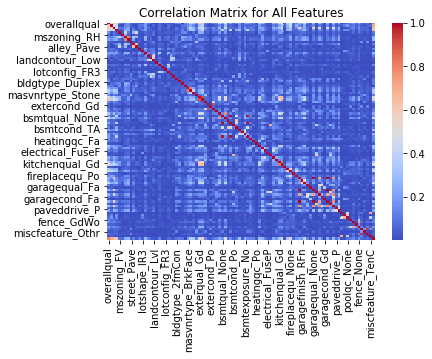

In [59]:
sns.heatmap(np.absolute(df3.corr()), cmap = 'coolwarm')
plt.title('Correlation Matrix for All Features')

Below are the 9 pairs that have correlations higher than 0.5 and one feature from each pair should be removed to meet the conditions of this assumption.

In [60]:
for i in range(len(df3.columns)-2):
    if np.absolute(df3[[df3.columns[i], df3.columns[i+1]]].corr())[df3.columns[i]][1] > 0.5:
        print(df3.columns[i], df3.columns[i+1])

overallqual grlivarea
mszoning_RL mszoning_RM
alley_None alley_Pave
masvnrtype_BrkFace masvnrtype_None
exterqual_Gd exterqual_TA
kitchenqual_Gd kitchenqual_TA
fireplacequ_Gd fireplacequ_None
garagefinish_RFn garagefinish_Unf
poolqc_Gd poolqc_None


#### 3.5 - Error Terms Should be Uncorrelated
A plot of the errros show that errors are random, **the assumptions of this condition are met.**

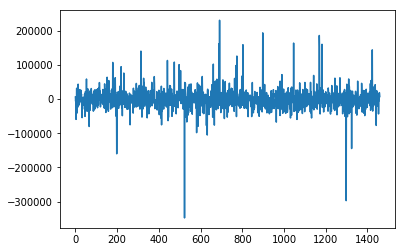

In [63]:
plt.plot(errors)

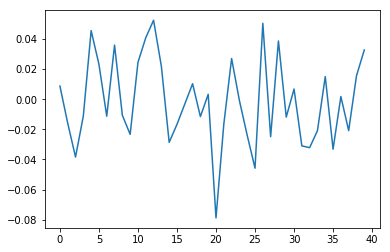

In [61]:
# acf= acf(errors)
# plt.plot(acf[1:])

#### 3.6 - Features Shouldn't be Correlated with the Errors
Instead of looking at a correlation matrix, I've decided to print any features that have a correlation higher than 0.5 with the error. In this case, there are none.  **The assumptions of this condition are met.**

In [62]:
for i in range(len(df3.columns)-1):
    if np.absolute(pd.concat([df3[df3.columns[i]], errors], axis = 1)).corr()[df3.columns[i]][1] > 0.5:
        print(df3.columns[i])